<a href="https://colab.research.google.com/github/PeterMnev/PeterMnev.github.io/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are astronauts up to on the ISS?
# Peter Mnev, Ryan Utz


## Introduction

Astronauts living on the [International Space Station](https://www.nasa.gov/mission_pages/station/main/index.html) (ISS) spend a significant portion of their time maintaining and repairing station systems. [Gateway](https://www.nasa.gov/topics/moon-to-mars/lunar-gateway), the next space station that the National Aeronautics and Space Administration (NASA) plans to launch, will be uncrewed for longer periods of time than the ISS. Both stations stand to benefit from the addition of new robotic systems, which could quicken or entirely automate certain maintenance and operational tasks, giving astronauts more time to conduct research and run the experiments they were initially tasked with.

Our goal is to use data science to track what tasks astronauts perform most often on the ISS. This will allow us to identify a set of tasks that an autonomous robotic system should be able to perform, and visualize what tasks are commonly performed close to each other. There is currently a lack of research in this area, which is why we are hopeful that this tutorial will provide an answer to this topic.

Our dataset is a [collection of PDF files](https://www.nasa.gov/mission_pages/station/timelines/index.html) from 2001-2014 detailing daily routines for each crew member. Each table in the file consists of a time, a list of crew to perform the task, and the task itself. The website itself is slightly cumbersome to parse through, so the PDF files have also been made available [here](https://github.com/PeterMnev/PeterMnev.github.io/tree/master/data).

## Obtaining the Dataset

Our first step is to convert these PDF files into raw CSV files, so that we can parse them into a pandas DataFrame. [tabula-py](https://pypi.org/project/tabula-py/) is a simple Python wrapper of tabula-java, which can read tables of PDF files. This package allows us to read tables from PDF and convert them into a pandas DataFrame. tabula-py also enables you to convert a PDF file into CSV/TSV/JSON file, which we will be doing.


In [0]:
!pip install tabula-py
import tabula

We then clone the dataset within our GitHub folders directly into our Jupyter notebook in order to have access to it.

In [47]:
#Need to do this every runtime, acquires the datas
!rm -rf "/content/PeterMnev.github.io"
!git clone https://github.com/PeterMnev/PeterMnev.github.io/

Cloning into 'PeterMnev.github.io'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (354/354), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 5316 (delta 162), reused 298 (delta 117), pack-reused 4962
Receiving objects: 100% (5316/5316), 321.08 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Checking out files: 100% (5303/5303), done.


In [48]:
!jupyter nbconvert --to html /content/PeterMnev.github.io/Final_Project.ipynb

[NbConvertApp] Converting notebook /content/PeterMnev.github.io/Final_Project.ipynb to html
[NbConvertApp] Writing 728033 bytes to /content/PeterMnev.github.io/Final_Project.html


For storing and manipulating our data, we are using the [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) and [numpy](https://numpy.org/) packages. These packages provide us with data structures and analysis tools to quantify and manipulate our data.

We'll also import some other packages that we'll be using up here.

In [2]:
!pip install pyvis

import pandas as pd
import numpy as np
import os
import glob
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from itertools import combinations
from dateutil import parser
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation as LDA #not to be confused with linear discriminant analysis
from sklearn.feature_extraction.text import CountVectorizer
from pyvis.network import Network

First, we take the raw PDF files and convert them into usable CSV files that we will later merge together. These CSV files are stored in a folder called [spreadsheets](https://github.com/PeterMnev/PeterMnev.github.io/tree/master/data/spreadsheets). Iterating through each folder, we convert the PDFs into CSVs so that we can analyze their output later. This is to ensure that minimal data is lost when transitioning from PDF format to a pandas DataFrame.

In [0]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

for i in range (2001, 2015):
  for j in range (0, 12):
    #There are no pdfs in December 2014 so this folder is skipped.
    if (i == 2014 and j == 11):
      break
    df_month = pd.DataFrame()
    directory = "PeterMnev.github.io/data/"+str(i)+"/"+months[j]+"/"
    dir_csv = "PeterMnev.github.io/data/spreadsheets/"+months[j]+str(i)+".csv"
    #If csv is already present, which it should be, does nothing.
    if os.path.isfile(dir_csv):
      pass
    else:
      for pdf in os.listdir(directory):
        pdf_filepath = directory+pdf
        print (pdf_filepath)
        print (i, months[j])
        table_read = tabula.read_pdf(pdf_filepath, pages="all", multiple_tables=True)
        if table_read:
          for k in table_read:
            #Filtering broken table reads
            k = k.loc[:, k.isnull().mean() < .8];
            print (k.shape)
            if (k.shape[1] > 1):
              df_month = df_month.append(k, sort=False)
      export_csv = df_month.to_csv (dir_csv, index = None, header=True)

## Cleaning the Dataset

Between 2001-2014, NASA used many different formatting strategies to store their routines. If you merge all the tables directly without any pre-processing, this creates a very unorganized table that ends up with around 15 columns for what should only require 3. This makes our job parsing the data much more difficult since the data doesn't neatly fit into their expected columns. While we couldn't predict the location of each point of data, through random sampling, we were able to figure out that for each row, Tabula would more often than not parse the time, then the crew, and then the task in that order.

Our new strategy to was to melt all of the data in a row into one entry, split up the tokens, and then reorganize the data into their correct columns. Sometimes, Tabula has a difficult time keeping the data from a row within that row when converting from PDF to CSV. To simplify our data analysis, we tossed any rows that don't start with an acceptable time signature (generally formatted as XX:XX-XX:XX). In addition, we also threw out any columns that were composed of 80% NaN values or higher. We attributed this error to Tabula occasionally parsing punctuation or other artifacts as its own row. The format of the tables changes every year, so we will assume that these errors are normally distributed when we sample our data.

To demonstrate why we need to melt the columns together, the output of the following code shows what Tabula stores in the first column for 50 randomly decided rows. Avert your eyes at the inconsistent file writing practices!

In [15]:
path = r'/content/PeterMnev.github.io/data/spreadsheets' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df.loc[:, df.isnull().mean() < .8];
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True, sort=False);
frame = frame[frame['0'].astype(str).str.match("^(\d{2}:\d{2}(-|–| – | - )\d{2}:\d{2})(.*)")]
frame['0'] = [re.sub(r'^(\d{2}:\d{2}(-|–| – | - )\d{2}:\d{2})(.*)', r'\1|\3', s) for s in frame['0']]
  
frame.sample(10)

,0,1,2,3,4,5
101981,15:00-15:20|,"CDR, FE-1",Closing Soyuz-FGB Transfer Hatches,NaN,NaN,NaN
116646,18:00-18:30|,NaN,CDR,CMO Proficiency Training,NaN,NaN
269218,08:10-08:20|,NaN,FE-6,NaN,MAKITA Battery Installation,NaN
19110,15:15–16:15|,FE-1,Physical exercise (cycle-2),NaN,NaN,NaN
185145,21:30-06:00|,.,Sleep,NaN,NaN,NaN
51575,12:25-13:05|,FE-1,СОЖ Maintenance,NaN,NaN,NaN
208329,14:05-14:35|,FE-6,Vessel Imaging Operations,NaN,NaN,NaN
256435,16:10-16:20|,NaN,FE-1,NaN,Replacing PILLE flash card,NaN
19996,13:45–16:30|,NaN,Personal hygiene (pre-sleep),NaN,NaN,NaN
177742,10:25-10:40|,CDR,Easter Greetings. Voice Conference with Patria...,NaN,NaN,NaN


So yeah, that's a mess that we need to deal with.

Following this, we replace all NaN values with empty strings, separate them with a '|' character, and concatenate them into a single row. This is okay to do because the first two sections of importance. Time and crew do not ever contain the '|' character. If the task description does, it will later be recombined into a single string regardless. The output of this DataFrame is still pretty bad, but it's a lot easier to deal with than managing inconsistent data across 6 columns.

In [14]:
df_concat = pd.DataFrame()
frame = frame.replace(np.nan, '', regex=True)
df_concat['long_string'] = ((frame['0']).astype(str) + "|" + (frame['1']).astype(str) +  "|" +  (frame['2']).astype(str) + "|" + (frame['3']).astype(str) + "|" +  (frame['4']).astype(str) + "|" + (frame['5']).astype(str))
df_concat.sample(10)

,long_string
118669,11:25–11:30||Inspection of БРПК-1 separator||||
22875,17:10-17:30|||FE-2||EVA Photo Downlink|
167599,08:55-09:25||FE-1|СОЖ maintenance|||
70898,06:00-06:05|||SLEEP - data logging|||
246384,08:15-08:45||FE-2|Prep for Work|||
233719,16:05-17:05||CDR|Physical Exercise (RED)|||
137328,14:00-14:40|||FE-5||HTV - HCP Stowage|
65567,"13:00-14:00|||CDR,FE-\r1,FE-2,||LUNCH|"
99786,15:30-00:00||SLEEP||||
92047,"13:10-14:10|||FE-5, FE-6||LUNCH|"


If you look in the table above, you'll be able to see the existence of a few Russian characters. The ISS is generally staffed by astronauts from multiple nations at a time, who bring equipment and crew members with their respective alphabets.

Now our data is generally in the following format, (time) | (crew) | (task).

However, now we need to split between the crew and the tasks. This is harder than it seems. For example, do you know whether a BT-7 is a piece of hardware that needs to be fixed, or a crew member? An FE-2? A CDR? A СОЖ? We'll have the answer to this later. This isn't even getting into the potential that data from tasks may bleed into the crew data due to errors caused by the Tabula program. 

To solve this, we will find the most common names in the crew line, and use those names to predict which of these tokens are actually crew members. We assume that the prevalence of correct crew members is more prominent than a consistent error made by Tabula.

In [13]:
def tokenizer (s, t):
  if (t): 
    return s.replace(" ", "").split(",")
  else: 
    return []

frame['tokens'] = [tokenizer(s,t) for (s,t)  in zip(frame['1'].astype(str), frame['2'].astype(str))]
tokens = frame['tokens']

tokens = tokens.explode()
tokens = tokens[tokens != ""]

tokens = tokens.dropna()
tokens.value_counts().head(15)

CDR        32021
FE-1       27166
FE-2       20652
FE-5        8105
FE-6        7759
FE-4        6377
.           6338
FE-3        5253
PLT          650
FE1VC        422
FE-2-16      410
VCCDR        379
VCSFP        271
\rFE-5       266
\rFE-4       250
Name: tokens, dtype: int64

Ok, it looks like CDR and FE were common crew member names, while BT-7 and СОЖ were tasks. It also looks like '.' was commonly parsed as a crew member, when it actually means all crew members. We'll remember this when we analyze our data.

Now, we'll organize our data and split them into the three columns we're looking for: Time, crew, and task.

In [18]:
def split_into_three_columns(long_string):

  lis = re.split('\|+', long_string)
  #lis = long_string.split("|")
  if any(lis[1].startswith(sub) for sub in tokens):
    lis = lis
  else:
    lis = [lis[0],".",lis[1]]
  if lis[2] != "":
    #Recombining the remainder of the list. this only returns lists of length 3 or None
    return [lis[0], lis[1], ''.join(lis[2:])]
df_splt = pd.DataFrame()
#THIS CODE IS ONLY FOR WHEN RUNNING TO RECREATE THE CSV
recreate_csv = False
if recreate_csv:
  df_splt['list'] = [split_into_three_columns(ls) for ls in df_concat['long_string']]
  ls = df_splt['list']
  ls = ls.dropna() #Dropping empty lists because the split method does return empty 
  df_final = pd.DataFrame(item for item in ls) #Makes a dataframe out of the Series of lists
  df_final.to_csv('/content/PeterMnev.github.io/data/final_data_2.csv') #Saves as CSV
else:
  df_final = pd.read_csv('/content/PeterMnev.github.io/data/final_data_2.csv')
df_final.head(10)

,Unnamed: 0,0,1,2
0,0,06:00–06:10,.,Morning inspection
1,1,06:10–06:40,.,Post-sleep
2,2,06:40–07:30,.,BREAKFAST
3,3,07:30–08:00,FE-1,Prep for work
4,4,07:55–08:00,.,PLANTS-2: payload status check
5,5,08:00–08:15,.,Daily planning conference (S-band)
6,6,08:15–11:15,.,Removal of KURS-A hardware from Progress M1-10
7,7,11:15–11:45,CDR,Disinfection of А-Р/Р-Р hoses prior to Progres...
8,8,11:15–11:25,FE-1,Increment 7 daily payload status
9,9,11:30–12:45,.,Physical exercise (TVIS)


These time stamps aren't particularly useful for us. Let's convert the times into duration, so we can see how long each task is performed.

In [20]:
def create_duration(t):
  times = re.match("^(\d{2}:\d{2})(-|–| – | - )(\d{2}:\d{2})", t)
  start = datetime.datetime.strptime(times[1], '%H:%M')
  end = datetime.datetime.strptime(times[3], '%H:%M')
  if (end < start): #day overlap handling
    end += datetime.timedelta(days=1)
  time_delta = end - start
  return time_delta

df_final['Duration'] = [create_duration(t) for t in df_final['0']]
df_final.head(10)

,Unnamed: 0,0,1,2,Duration
0,0,06:00–06:10,.,Morning inspection,00:10:00
1,1,06:10–06:40,.,Post-sleep,00:30:00
2,2,06:40–07:30,.,BREAKFAST,00:50:00
3,3,07:30–08:00,FE-1,Prep for work,00:30:00
4,4,07:55–08:00,.,PLANTS-2: payload status check,00:05:00
5,5,08:00–08:15,.,Daily planning conference (S-band),00:15:00
6,6,08:15–11:15,.,Removal of KURS-A hardware from Progress M1-10,03:00:00
7,7,11:15–11:45,CDR,Disinfection of А-Р/Р-Р hoses prior to Progres...,00:30:00
8,8,11:15–11:25,FE-1,Increment 7 daily payload status,00:10:00
9,9,11:30–12:45,.,Physical exercise (TVIS),01:15:00


Alright, we have a usable dataset now! This dataset (without any processing like durations) can be accessed as a CSV file from [here](https://github.com/PeterMnev/PeterMnev.github.io/blob/master/data/final_data_f.csv).

## Data Cleaning: Getting Rid of Common Tasks


Our goal is to figure out which tasks are most often performed on the ISS, as well as which tasks are closely related to each other. What's unique about our goal is that we're interested in some of the less common tasks that astronauts perform on the ISS. If you take the most common tasks that astronauts perform, you'll most likely find that eating, sleeping, inspections, and working out show up more often than not. We're interested in tasks that robots could perform autonomously, and most of the common tasks are those that robots are trying to eliminate for efficiency!

For data analysis, we simply use a heuristic and remove any tasks that appear more than 50 times. We assume that within 14 years (2001-2014), major repairs won't be needed more than ~3-4 times a year, NASA doesn't design things that badly!

A small note is that a heuristic is applied where СОЖ is replaced with LSS, an english equivalent acronym that stands for "Life Support System".

In [22]:
df_final['job_text_processed'] = df_final['2'].map(lambda x: re.sub('[,\.!?()\\-–:;\+=(\\r)/"\[\]]', '', x))
df_final['job_text_processed'] = df_final['2'].map(lambda x: re.sub('(СОЖ)', 'LSS', x))
# Convert the titles to lowercase
df_final['job_text_processed'] = df_final['job_text_processed'].map(lambda x: x.lower())
df_final_without_most_common = df_final.groupby('job_text_processed').filter(lambda x: len(x) <= 50)
df_final_without_most_common['job_text_processed'].value_counts().head(50)

crew handover                                                 50
flight director / iss crew tagup (ku + s-band)                50
ehs gc/dms ops terminate                                      50
fd / iss crew conference (s-band)                             50
jpm and lab window shutter closure                            50
private psychological conference (ku+s-band)                  50
verify ип-1 flow meter positions                              50
grab sample container (gsc) ops                               50
crew discretionary conference                                 49
rebooting oca ssc router                                      49
start filling cwc from the lab condensate tank                49
iss o2 repress from progress 354 српк (terminate)             49
physical exercise (tvis + red)                                49
daily diet monitoring                                         49
ehs - air quality monitor (aqm) end                           49
lab window shutter closur

This dataset, while somewhat readable, is still difficult to parse through. We'll use a [Word Cloud](https://github.com/amueller/word_cloud) to make the most common topics appear bigger.

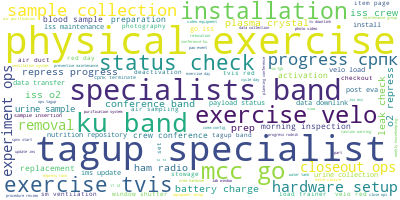

In [23]:
long_stringy = ','.join(list(df_final_without_most_common['job_text_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_stringy)
wordcloud.to_image()

It looks like physical exercise still made it through, but we can also see some smaller tasks that we want to consider having robots perform, such as checking for leaks and collecting samples. Now that we have a list of tasks that robots can perform, let's see which ones are related.

## Data Analysis: How long do astronauts spend performing tasks?

For the list of tasks that occur 50 or fewer times within the last 14 years, we want to find out how long it takes to perform each task. For each element in this list of tasks, we'll see if that element matches a task in the complete list. If it does, we'll add the duration.

In [28]:
df_uncommon_tasks = pd.DataFrame(df_final_without_most_common.groupby(['job_text_processed'])['Duration'].sum())
df_uncommon_tasks = df_uncommon_tasks.sort_values(by=['Duration'],ascending=False)
df_uncommon_tasks = df_uncommon_tasks.reset_index()
df_uncommon_tasks.head(50)

,job_text_processed,Duration
0,crew sleep,8 days 08:00:00
1,physical exercise (tvis + red),4 days 12:55:00
2,fgb цв2 fan cleaning,4 days 11:50:00
3,weekly housecleaning,4 days 06:55:00
4,bar experiment. tagup with specialists (s-band),3 days 08:30:00
5,eva prep,3 days 06:05:00
6,physical exercise ared,2 days 20:50:00
7,"бд-2 exercise, day 1",2 days 16:45:00
8,crew handover,2 days 15:55:00
9,sm ventilation system preventive maintenance. ...,2 days 15:50:00


Let's turn this into a bar plot.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


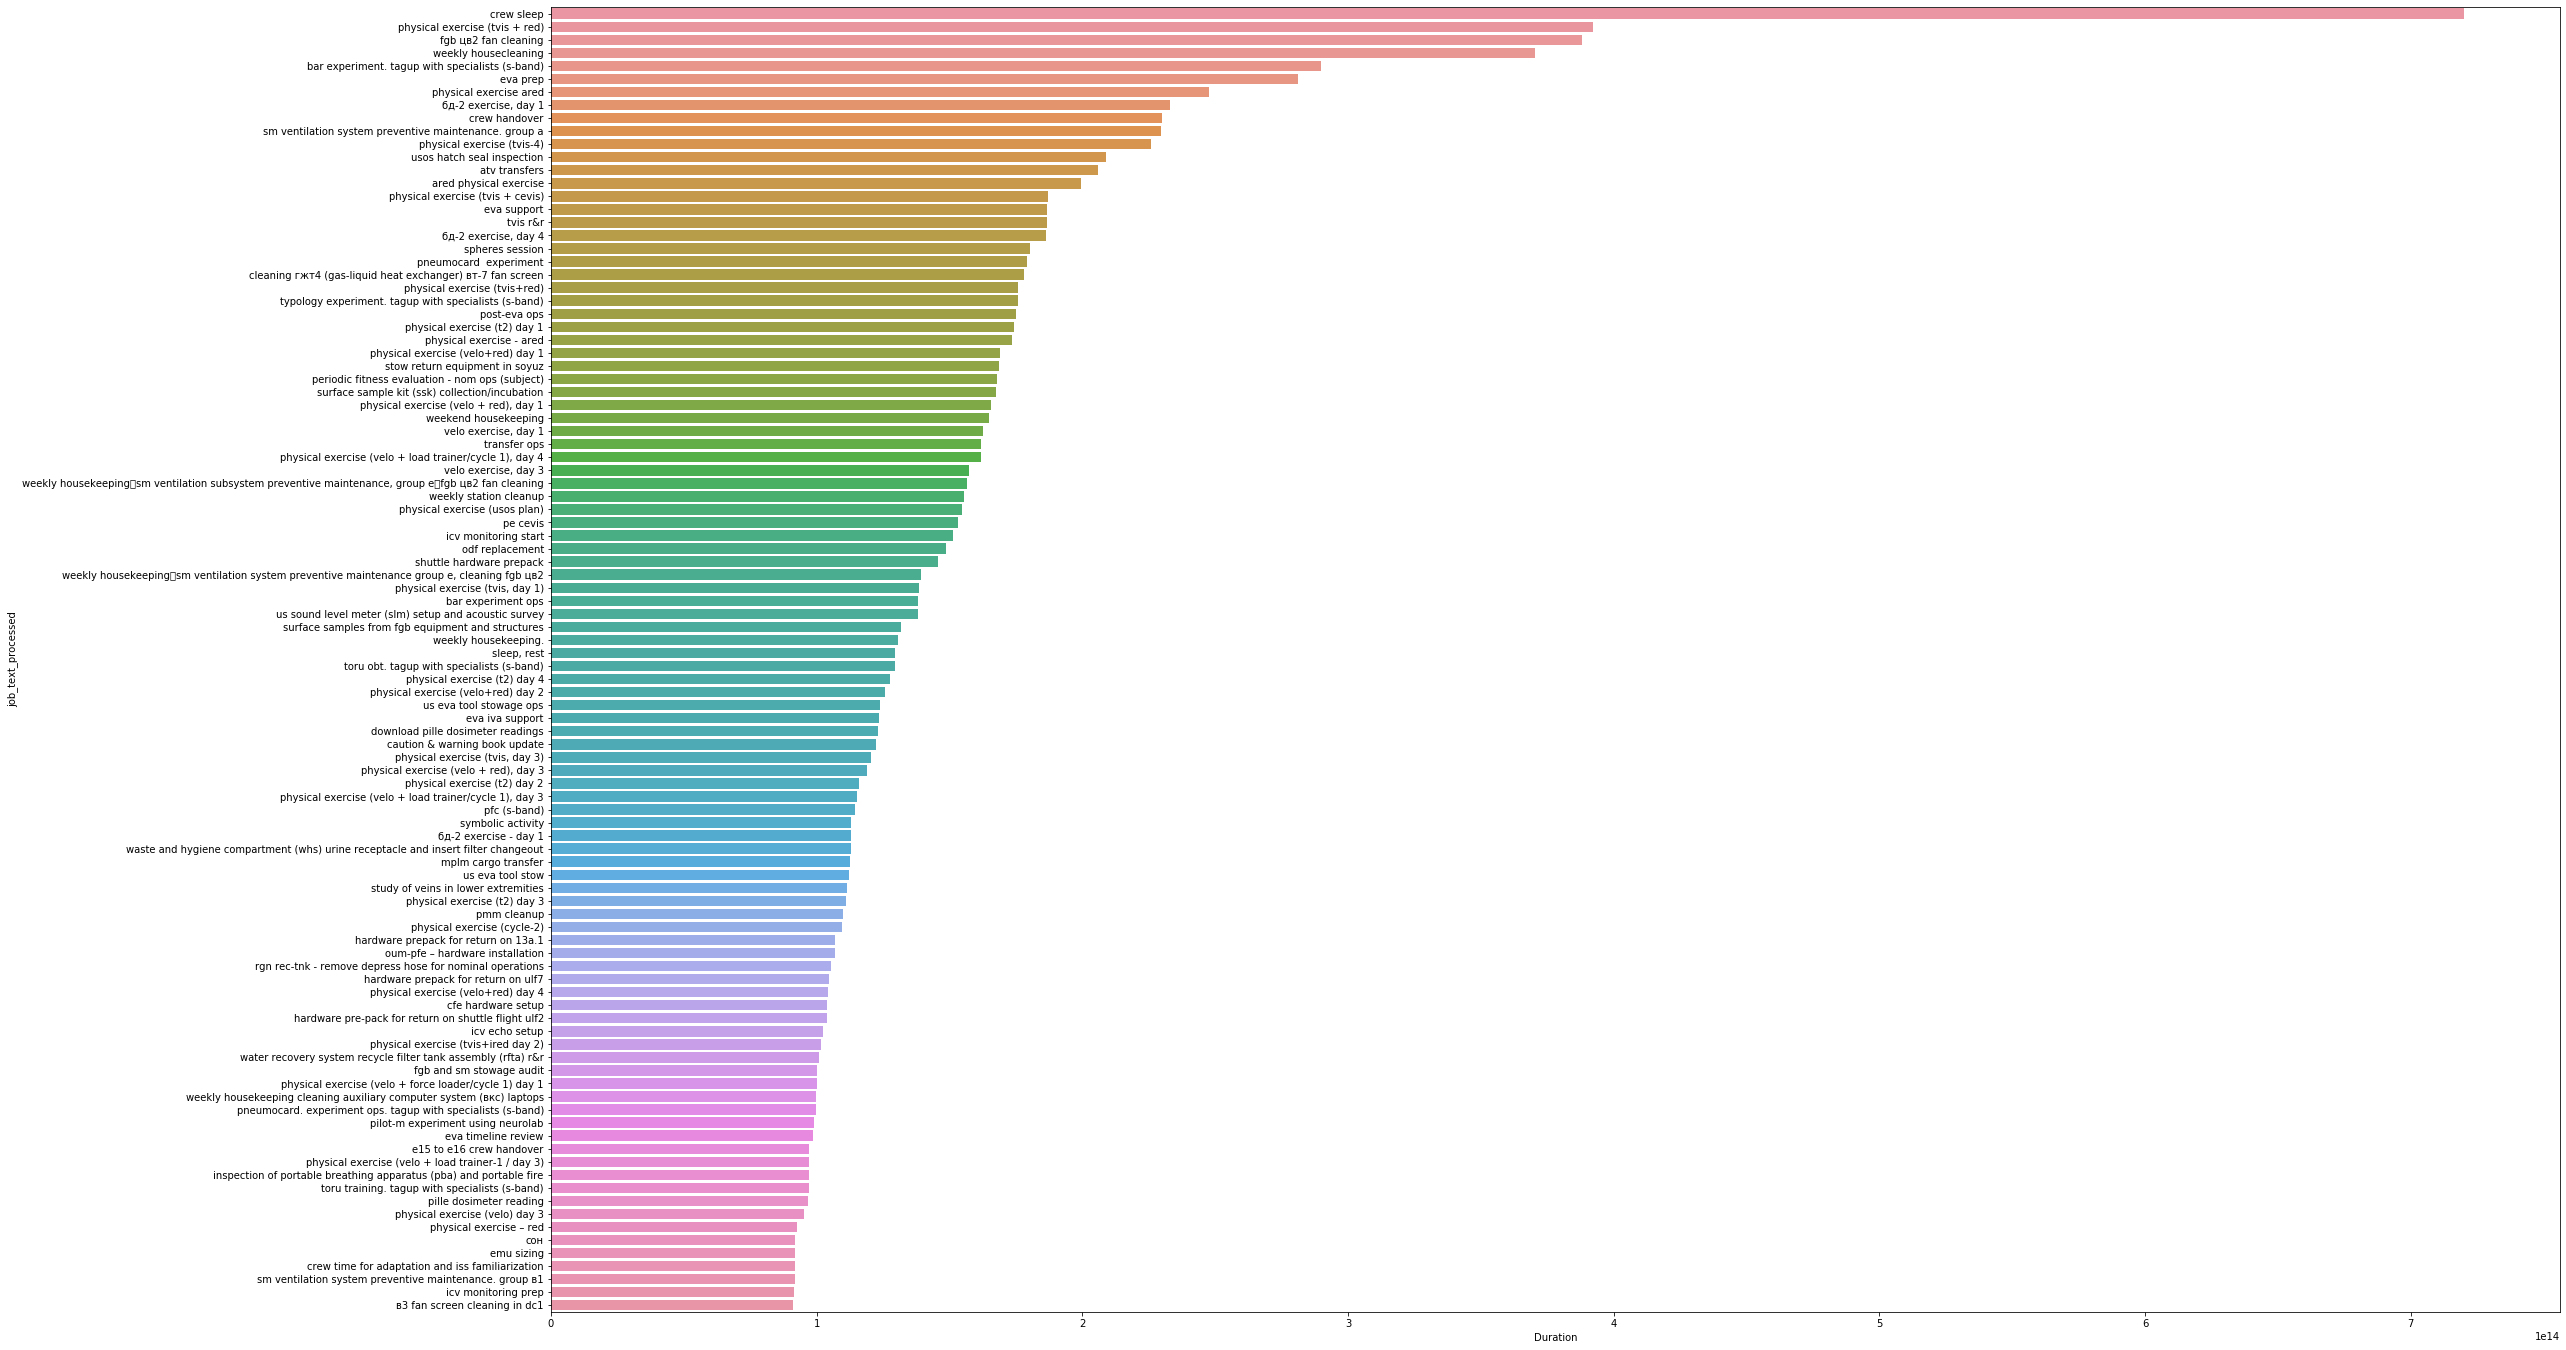

In [27]:
plt.figure(figsize=(36,24))
sns.barplot(df_uncommon_tasks['Duration'].head(100), df_uncommon_tasks['job_text_processed'].head(100))

While we'll probably have to do more searching to figure out what exact tasks robots need to be able to perform, at the very least, we have a very clear indicator that humans take up most of the time on the ISS doing, human things. Sleeping, eating, and exercising take up a significant portion of time that robots can help reduce.

One significant piece of data we noticed was ISS maintenance. If we research this subject further (for example, performing a literature review on what elements of the ISS are maintained during this time), this could be an avenue for us to design a robot that can accomplish those tasks.

## Data Analysis: Matching Tasks Together

To group tasks together, we are using [Latent Dirichlet Allocation](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) (LDA). LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities. This helps us find hidden structures in a collection of data, particularly, which tasks are related to one another.
The [hyperparameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) are the number of topics that we generate, and the number of words in each topic.

We further reduce our data by taking our previously generated list and removing [stop words](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words) such as "and", "the", and "a". This step helps remove unimportant words in the context of robotic space systems.

In [29]:
number_topics = 25
number_words = 5
lda = LDA(n_components=number_topics, n_jobs=-1, verbose=True)
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df_final_without_most_common['job_text_processed'])
lda.fit(count_data)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=25, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=True)

Let's test the output of our LDA model.

In [30]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
exercise physical day tvis velo

Topic #1:
soyuz progress hatch ims check

Topic #2:
activation water tank rodnik camcorder

Topic #3:
data downlink collection air copy

Topic #4:
deactivation sampling plasma installation crystal

Topic #5:
transfer data post eva sleep

Topic #6:
status check assembly evaluation periodic

Topic #7:
monitoring icv module hematocrit temperature

Topic #8:
experiment ops bag filter measurement

Topic #9:
radio review photography ham return

Topic #10:
band tagup specialists conference ku

Topic #11:
battery charge charging panel phone

Topic #12:
check payload status inspection reboot

Topic #13:
start iss progress repress српк

Topic #14:
video inspection maintenance elektron photo

Topic #15:
test health portable diet log

Topic #16:
cable node installation ssc power

Topic #17:
crew emu battery handover iss

Topic #18:
sample collection urine power hrf

Topic #19:
prep tv downlink pao то

Topic #20:
ops orlan closeout window lab

Topic #21:


It looks like we've generated some topics, however seeing the relations in between each topic is still difficult. Let's visualize this data using a [Network](https://pyvis.readthedocs.io/en/latest/).

First, among the 125 words generated from our LDA analysis, for each pair of unique words, we'll count how many instances both tokens are found within our reduced set of tasks. Each word is a node in our graph, and the number of common connections will be the weight of the edge. Only sufficiently strong ties are included to make connections more evident. The stronger the connection between two words is, the stronger the tie between two words will be, increasing their proximity and the edge thickness. The graph is interactive, explore it by zooming in and seeing which words are clustered together. Also try dragging individua nodes to see which ones they pull along with them.

In [0]:
generate_new = False
def concat_topics(model, count_vectorizer, n_top_words):
  words = count_vectorizer.get_feature_names()
  topic_list = []
  for topic_idx, topic in enumerate(model.components_):
    for i in topic.argsort()[:-n_top_words - 1:-1]:
      topic_list.append(words[i])
  return topic_list
if generate_new:
  topics = concat_topics(lda, count_vectorizer, 5)
  topics = pd.Series(topics).drop_duplicates()
  topics = pd.DataFrame(topics)
  topics['count'] = [df_final['job_text_processed'].str.count(s).sum() for s in topics[0]]
else:
  topics = pd.read_csv('/content/PeterMnev.github.io/data/topics.csv')

In [38]:
if generate_new:
  ndf = list(combinations(topics[0], 2))
  ndf = pd.DataFrame(ndf)
  generate_new = False
  ndf['count'] = [pd.Series([all(x in string for x in [s,t]) for string in df_final_without_most_common['job_text_processed']]).sum() for (s,t) in zip(ndf[0],ndf[1])]
else:
  ndf = pd.read_csv('/content/PeterMnev.github.io/data/pairwise_counts.csv')

0           sample
1       conference
2            melfi
3            sband
4           camera
           ...    
5990       repress
5991           mcc
5992       repress
5993           mcc
5994           mcc
Name: 1, Length: 5995, dtype: object

In [0]:
net = Network()
for index,row in topics.iterrows():
  net.add_node(row['0'],value=row['count'], labelHighlightBold = True)
for index,row in ndf.iterrows():
  if (row['count'] > 200):
    net.add_edge(row['0'], row['1'], weight = row['count']*.01, width=row['count']*.0075)   
#net.show_buttons()
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "strokeWidth": 15
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -28728,
      "centralGravity": 7.5,
      "avoidOverlap": 0.9
    },
    "minVelocity": 0.75
  }
}
""")
net.save_graph("mygraph.html")



Unfortunately this nice graph does not load properly in GitHub because JavaScript is disabled. In order to view it, please download the html for the graph here: [GraphHTML](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/PeterMnev/PeterMnev.github.io/blob/master/mygraph.html). Then you should receive a zip file containing the graph from our Github. You can see the file in our github repository as well should you want to view what this is downloading. Then, after opening the zip folder, open up the HTML that is contained inside and play around with the graph there. The code above is what was used to produce it, but is not actually going to make any output unfortunately.